## Setup

In [1]:
import sys
sys.path.append('../')
del sys
%reload_ext autoreload
%autoreload 2

In [2]:
from modeling.pipeline import Pipeline
from modeling.nn import MLP
from modeling.utils import rank, ap_at_k, ndcg

import torch
from numpy import mean, arange
import matplotlib.pyplot as plt

## Display functions

In [3]:
def show_pipeline(pipeline):
    for inputs, targets in pipeline.train_loader[:10]:
        print("\nInputs:")
        for key, item in inputs.items():
            print(key, ':', item)

        print("\nTargets:")
        print(targets)

        if sum(targets) > 0:
            print("Good answers:")
            for i in range(len(targets)):
                if targets[i]:
                    print(inputs['choices'][i])
                    
def show_model(pipeline, model):
    for inputs, targets in pipeline.train_loader[:100]:
        features = model.features(inputs)
        outputs = model.pred(features)
        ranks = rank(outputs)
        score = model.score(ranks, targets, model.k)

        if sum(targets) > 0:
            mask = targets > 0
            grades = outputs[:, 1][mask]
            ranks = ranks[mask]
            print("score: %.3f" % score)
            print("ranks of the true labels:", ranks, ", grades of the true labels:", grades)
            print()
            
def plot_metrics(train_losses, train_scores, valid_losses, valid_scores):
    epoch_number, epoch_length = len(train_losses), len(train_losses[0])

    x1 = arange(0, epoch_number, 1./epoch_length)
    x2 = arange(1, epoch_number + 1)

    flatten_train_losses = [loss for epoch_losses in train_losses for loss in epoch_losses]
    flatten_train_scores = [score for epoch_scores in train_scores for score in epoch_scores]
    flatten_valid_losses = [mean(losses) for losses in valid_losses]
    flatten_valid_scores = [mean(scores) for scores in valid_scores]

    fig, ax1 = plt.subplots(figsize=(15, 5))
    ax1.set_xlabel('epochs')

    color = 'tab:red'
    ax1.set_yscale('log')
    ax1.plot(x1, flatten_train_losses, color=color, label='train loss')
    ax1.set_ylabel('loss', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    color = 'tab:orange'
    ax1.scatter(x2, flatten_valid_losses, color=color, label='valid loss')

    color = 'tab:blue'
    ax2 = ax1.twinx()
    ax2.plot(x1, flatten_train_scores, color=color, label='score')
    ax2.set_ylabel('score', color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    color = 'tab:cyan'
    ax1.scatter(x2, flatten_valid_scores, color=color, label='valid scores')

    fig.legend()

## Data pipeline parameters

In [4]:
batch_size = 32
drop_last = False
test_proportion = 0.25
valid_proportion = 0.25
use_k_fold = False
k_k_fold = None

## Score

In [5]:
score = ap_at_k
k_score = 10
n_updates = 100

## Load the data

In [6]:
pipeline = Pipeline(use_k_fold=use_k_fold)
pipeline.process_data(batch_size=batch_size,
                      drop_last=drop_last,
                      test_proportion=test_proportion,
                      valid_proportion=valid_proportion,
                      k=k_k_fold)

Processing the modeling task...
Computing the annotated queries...
Initial length of queries: 0
Object loaded from ../results/../results/task_annotation/v2_0/task/queries_size10k_shuffle_articles1_queries1_seed0.pkl
Object loaded from ../results/../results/task_annotation/v2_1/task/queries_sizemax_shuffle_articles1_queries1_seed0.pkl
Object loaded from ../results/../results/task_annotation/v2_2/task/queries_sizemax_shuffle_articles1_queries1_seed0.pkl
Final length of queries: 61056
Done (elapsed time: 1s).

Computing the annotations...
Initial length of annotations: 0
Object loaded from ../results/task_annotation/v2_0/results/batch_00_complete.csv
   Correcting "n this article, Nevada and Ohio are discussed. The two American states..." to " The two American states..."
   Correcting "In this article, California and Oregon are discussed. The two neighboring states..." to " The two neighboring states..."
   Correcting "In this article, California and Oregon are discussed. The two West Coa

## Oberseve the data

In [7]:
show_pipeline(pipeline)


Inputs:
entities_type_ : person
entities : ['Bill Ryan', 'Joseph M. Delfino']
summaries : ['William Emmett Ryan III was an American broadcast journalist with the NBC television network and its owned and operated local station WNBC-TV in New York City for 26 years, and also served for a year as news anchor at WOR-TV. Bill Ryan was also co-anchor of the Ralph & Ryan radio morning show on 570 WMCA in the late 1970s to early 1980s in New York City.', 'No information found.']
context : Mayor and Legislator Squabble Over Building Site: But they disagree on who should control the project. Mr. Delfino said it should be the city; Mr. Ryan , the county.
choices : ['new york city government officials', 'notable new yorkers', 'united states politicians', 'manufacturing executives', 'dog enthusiasts', 'fishermen', 'spouses', 'american political scientists', 'german businessmen', 'lobbyists', 'ex coworkers', 'afghan politicians', 'tennis professionals', 'kazakh government officials', 'political fig

## Baselines

### Random

In [11]:
from modeling.models import RandomBaseline

model = RandomBaseline(score=score, k=k_score)
pipeline.preview_data(model=model, include_valid=True)

In [12]:
scores = pipeline.evaluate_baseline(model=model, n_updates=n_updates)

Evaluation of the model...




Test Score: 0.009


In [10]:
show_model(pipeline, model)

score: 0.000
ranks of the true labels: tensor([23.]) , grades of the true labels: tensor([0.1908])

score: 1.000
ranks of the true labels: tensor([1.]) , grades of the true labels: tensor([0.9784])

score: 0.333
ranks of the true labels: tensor([3.]) , grades of the true labels: tensor([0.9522])

score: 0.000
ranks of the true labels: tensor([24.]) , grades of the true labels: tensor([0.3031])

score: 0.000
ranks of the true labels: tensor([19.]) , grades of the true labels: tensor([0.2931])

score: 0.125
ranks of the true labels: tensor([8.]) , grades of the true labels: tensor([0.8419])

score: 0.000
ranks of the true labels: tensor([24.]) , grades of the true labels: tensor([0.4016])

score: 0.000
ranks of the true labels: tensor([30.]) , grades of the true labels: tensor([0.0281])

score: 0.000
ranks of the true labels: tensor([25.]) , grades of the true labels: tensor([0.1555])

score: 0.000
ranks of the true labels: tensor([30.]) , grades of the true labels: tensor([0.0510])

sco

### Counts

In [11]:
from modeling.models import CountsBaseline

model = CountsBaseline(score=score, k=k_score)
pipeline.preview_data(model=model, include_valid=True)

Learning answers counts...


In [12]:
scores = pipeline.evaluate_baseline(model=model, n_updates=n_updates)

Evaluation of the model...




Test Score: 0.063


In [13]:
show_model(pipeline, model)

score: 0.000
ranks of the true labels: tensor([11.]) , grades of the true labels: tensor([0.0116])

score: 0.500
ranks of the true labels: tensor([2.]) , grades of the true labels: tensor([0.5312])

score: 0.000
ranks of the true labels: tensor([14.]) , grades of the true labels: tensor([0.0500])

score: 1.000
ranks of the true labels: tensor([1.]) , grades of the true labels: tensor([1.])

score: 1.000
ranks of the true labels: tensor([1.]) , grades of the true labels: tensor([1.])

score: 0.500
ranks of the true labels: tensor([2.]) , grades of the true labels: tensor([0.6000])

score: 1.000
ranks of the true labels: tensor([1.]) , grades of the true labels: tensor([1.])

score: 1.000
ranks of the true labels: tensor([1.]) , grades of the true labels: tensor([1.])

score: 1.000
ranks of the true labels: tensor([1.]) , grades of the true labels: tensor([1.])

score: 1.000
ranks of the true labels: tensor([1.]) , grades of the true labels: tensor([1.])

score: 0.000
ranks of the true l

### Summaries Counts

In [14]:
from modeling.models import SummariesCountBaseline

model = SummariesCountBaseline(score=score, k=k_score)
pipeline.preview_data(model=model, include_valid=True)

In [15]:
scores = pipeline.evaluate_baseline(model=model, n_updates=n_updates)

Evaluation of the model...




Test Score: 0.027


In [16]:
show_model(pipeline, model)

score: 0.500
ranks of the true labels: tensor([2.]) , grades of the true labels: tensor([1.])

score: 1.000
ranks of the true labels: tensor([1.]) , grades of the true labels: tensor([1.])

score: 1.000
ranks of the true labels: tensor([1.]) , grades of the true labels: tensor([1.])

score: 0.000
ranks of the true labels: tensor([30.]) , grades of the true labels: tensor([0.])

score: 0.000
ranks of the true labels: tensor([30.]) , grades of the true labels: tensor([0.])

score: 0.100
ranks of the true labels: tensor([10.]) , grades of the true labels: tensor([0.])

score: 0.000
ranks of the true labels: tensor([23.]) , grades of the true labels: tensor([0.])

score: 0.000
ranks of the true labels: tensor([23.]) , grades of the true labels: tensor([0.])

score: 0.000
ranks of the true labels: tensor([18.]) , grades of the true labels: tensor([0.])

score: 0.000
ranks of the true labels: tensor([29.]) , grades of the true labels: tensor([0.])

score: 0.000
ranks of the true labels: tens

### Summaries Overlap

In [17]:
from modeling.models import SummariesOverlapBaseline

model = SummariesOverlapBaseline(score=score, k=k_score)
pipeline.preview_data(model=model, include_valid=True)

In [18]:
scores = pipeline.evaluate_baseline(model=model, n_updates=n_updates)

Evaluation of the model...




Test Score: 0.023


In [19]:
show_model(pipeline, model)

score: 0.500
ranks of the true labels: tensor([2.]) , grades of the true labels: tensor([1.])

score: 0.111
ranks of the true labels: tensor([9.]) , grades of the true labels: tensor([1.])

score: 1.000
ranks of the true labels: tensor([1.]) , grades of the true labels: tensor([1.])

score: 0.000
ranks of the true labels: tensor([30.]) , grades of the true labels: tensor([0.])

score: 0.000
ranks of the true labels: tensor([30.]) , grades of the true labels: tensor([0.])

score: 0.100
ranks of the true labels: tensor([10.]) , grades of the true labels: tensor([0.])

score: 0.000
ranks of the true labels: tensor([23.]) , grades of the true labels: tensor([0.])

score: 0.000
ranks of the true labels: tensor([23.]) , grades of the true labels: tensor([0.])

score: 0.000
ranks of the true labels: tensor([18.]) , grades of the true labels: tensor([0.])

score: 0.000
ranks of the true labels: tensor([29.]) , grades of the true labels: tensor([0.])

score: 0.000
ranks of the true labels: tens

## Models
### Loss

In [8]:
loss = torch.nn.CrossEntropyLoss()

### BOW

In [9]:
from modeling.models import BOWModel

model = BOWModel(min_vocab_frequency=100, net=None, optimizer=None, loss=loss, score=score, k=k_score)
pipeline.preview_data(model=model, include_valid=False)

Learning the vocabulary...



Input size: 5538


In [10]:
model.net = MLP(input_dim=5538,
                hidden_dim=500,
                output_dim=2,
                dropout=0.25)
model.optimizer = torch.optim.Adam(model.net.parameters(),
                                   lr=1e-5)

In [11]:
train_losses, train_scores, valid_losses, valid_scores = pipeline.train_model(model=model, 
                                                                              n_epochs=5, 
                                                                              n_updates=500)

Training of the model...




Epoch 1/5: Validation Loss: 0.273 Validation Score: 0.246
--------------------------------------------------------------



Epoch 2/5: Validation Loss: 0.273 Validation Score: 0.252
--------------------------------------------------------------



Epoch 3/5: Validation Loss: 0.273 Validation Score: 0.259
--------------------------------------------------------------



Epoch 4/5: Validation Loss: 0.273 Validation Score: 0.251
--------------------------------------------------------------



Epoch 5/5: Validation Loss: 0.273 Validation Score: 0.257
--------------------------------------------------------------


In [29]:
for inputs, targets in pipeline.train_loader:
    print(model.loss(model.net(model.features(inputs)),targets))
    
    break

tensor(0.3133, grad_fn=<NllLossBackward>)


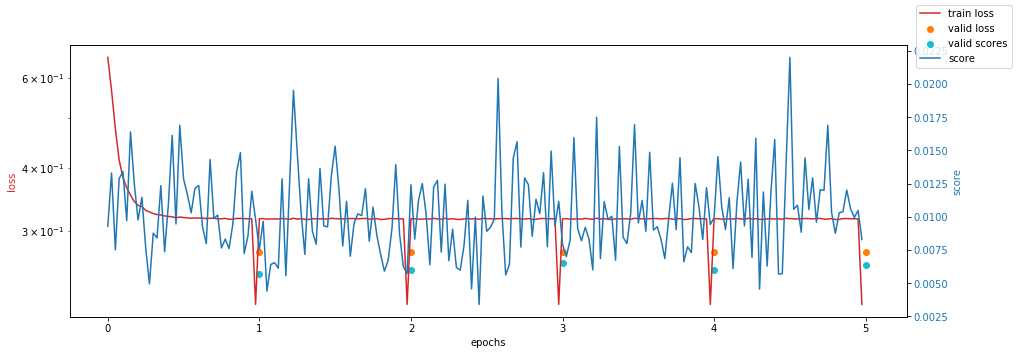

In [12]:
plot_metrics(train_losses, train_scores, valid_losses, valid_scores)

### Embedding

In [13]:
from modeling.models import EmbeddingModel

model = EmbeddingModel(net=None, optimizer=None, loss=loss, score=score, k=k_score)
pipeline.preview_data(model=model, include_valid=False)

Initializing the Word2Vec embedding...
Initializing the FreeBase embedding...
Input dimension: 1600


In [14]:
model.net = MLP(input_dim=1600,
                hidden_dim=500,
                output_dim=2,
                dropout=0.1)
model.optimizer = torch.optim.Adam(model.net.parameters(),
                                   lr=1e-5)

In [15]:
train_losses, train_scores, valid_losses, valid_scores = pipeline.train_model(model=model, 
                                                                              n_epochs=5, 
                                                                              n_updates=500)

Training of the model...




Epoch 1/5: Validation Loss: 0.273 Validation Score: 0.004
--------------------------------------------------------------



Epoch 2/5: Validation Loss: 0.273 Validation Score: 0.003
--------------------------------------------------------------



Epoch 3/5: Validation Loss: 0.273 Validation Score: 0.004
--------------------------------------------------------------



Epoch 4/5: Validation Loss: 0.273 Validation Score: 0.004
--------------------------------------------------------------



Epoch 5/5: Validation Loss: 0.273 Validation Score: 0.005
--------------------------------------------------------------


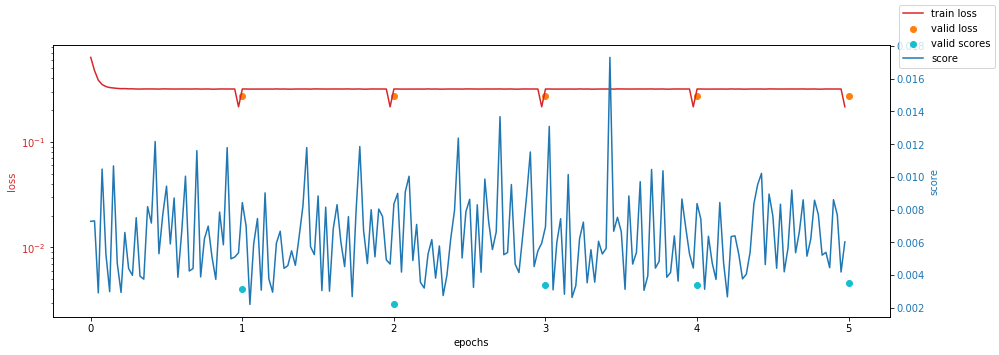

In [16]:
plot_metrics(train_losses, train_scores, valid_losses, valid_scores)

In [ ]:
epoch_number, epoch_length = len(train_losses), len(train_losses[0])

x1 = arange(0, epoch_number, 1./epoch_length)
x2 = arange(1, epoch_number + 1)

flatten_train_losses = [loss for epoch_losses in train_losses for loss in epoch_losses]
flatten_train_scores = [score for epoch_scores in train_scores for score in epoch_scores]
flatten_valid_losses = [mean(losses) for losses in valid_losses]
flatten_valid_scores = [mean(scores) for scores in valid_scores]

fig, ax1 = plt.subplots(figsize=(15, 5))
ax1.set_xlabel('epochs')

color = 'tab:red'
ax1.set_yscale('log')
ax1.plot(x1, flatten_train_losses, color=color, label='train loss')
ax1.set_ylabel('loss', color=color)
ax1.tick_params(axis='y', labelcolor=color)
color = 'tab:orange'
ax1.scatter(x2, flatten_valid_losses, color=color, label='valid loss')

color = 'tab:blue'
ax2 = ax1.twinx()
ax2.plot(x1, flatten_train_scores, color=color, label='score')
ax2.set_ylabel('score', color=color)
ax2.tick_params(axis='y', labelcolor=color)
color = 'tab:cyan'
ax1.scatter(x2, flatten_valid_scores, color=color, label='valid scores')

fig.legend()